## 102 Flowers recognition GF version
This notebook trains a ResNet34 to recognise 102 common British flowers from the  <a href="http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html"> Oxford 102 Flowers data set.</a> The data set was created by the Visual Geometry Group at Oxford University in 2008. It includes 8,189 images of <a href="http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html "> a range of flowers.</a> 
<br> In <a href='http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.pdf'>the original paper</a>, the authors trained a SVM, eventually achieving an accuracy of 72.8%. Initially, the original work is duplicated: the ResNet was trained using exactly the same training and validation sets, first on half size images, then on full size. This achieved an accuracy of 80.0%.
<br> However, the paper explains that the training and validation sets each included just 10 images of each flower, while the test set included 6,149 images. These relatively small files had allowed me to do initial training on the CPU of my MacBook Pro. Nevertheless, in order to improve the model, I merged the test set into the training set and held out the orginial vaidation set for testing. After about 45 minutes of additional training on a GPU, an accuracy of 97.0% was attaned.
<br> Final model deployed at https://flower-identifier-pjb6.onrender.com/

In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [24]:
path = untar_data(URLs.FLOWERS)
path.ls()

[PosixPath('/storage/oxford-102-flowers/train.txt'),
 PosixPath('/storage/oxford-102-flowers/jpg'),
 PosixPath('/storage/oxford-102-flowers/test.txt'),
 PosixPath('/storage/oxford-102-flowers/valid.txt')]

In [25]:
path_img = path/'jpg'

It is straightforward to see the image classes, but there doesn't seem to be an easy way to convert the classes to names

In [26]:
trn =pd.read_csv(path/'train.txt', sep=" ", header=None)
val = pd.read_csv(path/'valid.txt', sep=" ", header=None)
tst = pd.read_csv(path/'test.txt', sep=" ", header=None)
df = trn.append(val, ignore_index=True).append(tst, ignore_index=True)
df.columns=['Img','Class']
df.index=df.Img
df.head()

,Img,Class
Img,,
jpg/image_03860.jpg,jpg/image_03860.jpg,16
jpg/image_06092.jpg,jpg/image_06092.jpg,13
jpg/image_02400.jpg,jpg/image_02400.jpg,42
jpg/image_02852.jpg,jpg/image_02852.jpg,55
jpg/image_07710.jpg,jpg/image_07710.jpg,96


In [27]:
len(trn), len(val), len(tst)

(1020, 1020, 6149)

## Obtain names for classes
Scrape the sample images on the website, then look up the labels in the combined training, validation, test set.

In [28]:
from bs4 import BeautifulSoup
import re


In [29]:
url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html'
r= requests.get(url)

soup = BeautifulSoup(r.content, "lxml")
ims = soup.findAll('img')

In [30]:
sample = {}
for im in ims[1:]:
    sample[f"jpg/image_{im['src'].split('_')[-1]}"] = im['alt']
len(sample.keys()), {k: sample[k] for k in list(sample)[:5]}

(102,
 {'jpg/image_06974.jpg': 'alpine sea holly',
  'jpg/image_04657.jpg': 'buttercup',
  'jpg/image_06779.jpg': 'fire lily',
  'jpg/image_02011.jpg': 'anthurium',
  'jpg/image_03206.jpg': 'californian poppy'})

In [31]:
names = {}
for im in sample.keys():
            names[df.loc[im]['Class']] = sample[im] 
            
{k: names[k] for k in list(names)[:5]}

{34: 'alpine sea holly',
 47: 'buttercup',
 20: 'fire lily',
 79: 'anthurium',
 64: 'californian poppy'}

In [32]:
codes = np.array([names[i] for i in range(len(names))]); codes


array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', ..., 'bromelia',
       'blanket flower', 'trumpet creeper', 'blackberry lily'], dtype='<U25')

In [33]:
trn[trn.columns[-1]] = trn[trn.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))
val[val.columns[-1]] = val[val.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))
tst[tst.columns[-1]] = tst[tst.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))


## Data

In [35]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/storage/oxford-102-flowers/jpg/image_05071.jpg'),
 PosixPath('/storage/oxford-102-flowers/jpg/image_07395.jpg'),
 PosixPath('/storage/oxford-102-flowers/jpg/image_00878.jpg')]

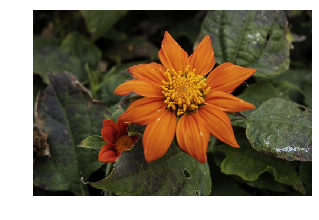

In [36]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [37]:
src_size = min(img.size)

## Datasets

In [38]:
size = src_size//2
bs =4
#free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
#if free > 8200: bs=8
#else:           bs=4
#print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [39]:
trnList = ImageList.from_df(df=trn, path=path)
valList = ImageList.from_df(df=val, path=path)
tstList = ImageList.from_df(df=tst, path=path)


In [40]:
src = (ImageList.from_folder(path)
       .split_by_list(trnList, valList)
       .label_from_df()
       )

In [41]:
data = (src.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

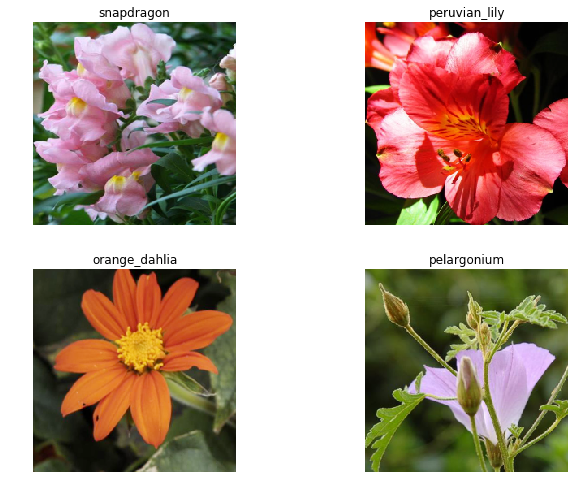

In [42]:
data.show_batch(4, figsize=(10,7))

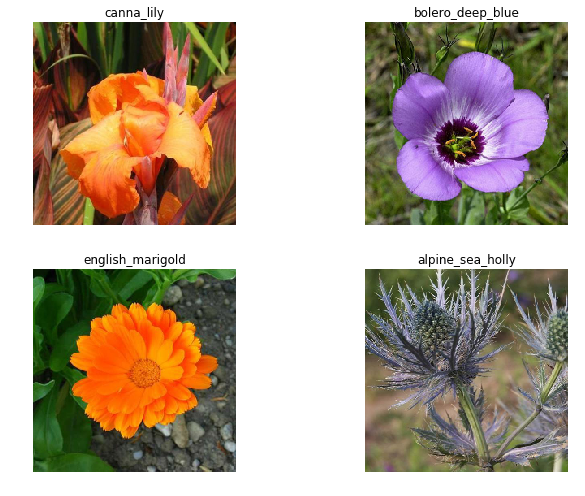

In [43]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:

metrics=accuracy

In [ ]:
#wd=1e-2

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=metrics)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=4, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

In [ ]:
learn.show_results(ds_type=DatasetType.Valid, rows=4, figsize=(8,9))

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
metrics = accuracy
size = src_size
bs = 4
#learn.destroy()

#size = src_size

#free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
#if free > 8200: bs=3
#else:           bs=1
#print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=metrics)

In [ ]:
#learn.load('stage-2');

In [ ]:
#lr_find(learn)
#learn.recorder.plot()

In [ ]:
#lr=5e-5

In [ ]:
#learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
#learn.save('stage-1-big')

In [ ]:
#learn.load('stage-1-big');

In [ ]:
#learn.unfreeze()

In [ ]:
#lrs = slice(1e-7,lr/10)

In [ ]:
#learn.fit_one_cycle(10, lrs)

In [ ]:
#learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.export()

## Check accuracy

In [ ]:
fname = '/Users/Gavin/Downloads/IMG_0650.jpg'
img = open_image(fname)

preds = learn.predict(img)
img.show(figsize=(5,5))#, title=str(preds[0]))
top3 = sorted(zip(np.array(preds[2])*100, data.classes), reverse=True)[:3]
rep = '\n'.join([f'{p:.0f}% {g}' for p,g in top3]);rep

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)


In [ ]:
accuracy(preds,y)

## Test set

In [ ]:
src2 = (ImageList.from_folder(path)
       .split_by_list(trnList, tstList)
       .label_from_df()
       )
data2 = (src2.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn2 = cnn_learner(data2, models.resnet34, metrics=metrics)
learn2.load('stage-2-big');


In [ ]:
preds,y,losses = learn2.get_preds(with_loss=True)
accuracy(preds,y)

In [ ]:
len(trn),len(val),len(tst)

# What about a better allocation of the data to training?
- Take the current model, but add the 6149 test images to the training data and use the validation set as the test set.
- OK that's too slow for my MacBook Pro. It needs to go on the GPU

In [44]:
bs = 8
size = src_size
metrics=accuracy

In [45]:
src3 = (ImageList.from_df(df=trn.append(tst, ignore_index=True), path=path)
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_df()
       )
data3 = (src3.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data3, models.resnet34, metrics=metrics)

In [46]:
learn.load('stage-2-big');

In [47]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


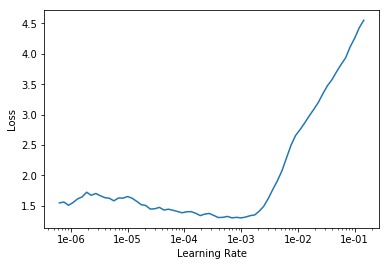

In [48]:
lr_find(learn)
learn.recorder.plot()

In [49]:
lr=5e-5

In [50]:
lrs = slice(1e-7,lr/10)

In [51]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,1.320178,0.633376,0.838102,02:06
1,1.236271,0.544583,0.863922,02:09
2,1.076014,0.497699,0.875087,02:09
3,1.096894,0.432344,0.889742,02:09
4,0.864664,0.382266,0.898814,02:09
5,0.918410,0.366579,0.905792,02:09
6,0.929852,0.351265,0.912073,02:09
7,0.896674,0.339179,0.914864,02:09
8,0.811240,0.339349,0.916260,02:09
9,0.818525,0.336288,0.914864,02:09


In [52]:
learn.save('stage-3-bigTrain')

It looks like this needs a bit more training. Try widening the learning rate range

In [53]:
lr=5e-3
lrs = slice(1e-7,lr/10)

In [54]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,accuracy,time
0,0.771179,0.283484,0.928123,02:07
1,0.606586,0.211194,0.954641,02:09
2,0.487337,0.163814,0.965806,02:09
3,0.332693,0.139627,0.969295,02:09
4,0.232423,0.117347,0.972087,02:09
5,0.191240,0.121919,0.972784,02:09
6,0.153599,0.104272,0.976274,02:09
7,0.144009,0.100982,0.979763,02:09
8,0.144729,0.098670,0.979065,02:09
9,0.123082,0.097248,0.979763,02:09


In [55]:
learn.save('stage-3-bigTrain')

In [56]:
learn.export()

Now check accuracy on the original validation set that was held out of this round of training. Accuracy of 97% is pretty amazing.

In [57]:
src2 = (ImageList.from_folder(path)
       .split_by_list(trnList, valList)
       .label_from_df()
       )
data2 = (src2.transform(get_transforms(), size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn2 = cnn_learner(data2, models.resnet34, metrics=metrics)
learn2.load('stage-3-bigTrain');

Learner(data=ImageDataBunch;

Train: LabelList (1020 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
purple_coneflower,spear_thistle,sword_lily,bishop_of_llandaff,mallow
Path: /storage/oxford-102-flowers;

Valid: LabelList (1020 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
canna_lily,bolero_deep_blue,english_marigold,alpine_sea_holly,anthurium
Path: /storage/oxford-102-flowers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [58]:
preds,y,losses = learn2.get_preds(with_loss=True)
accuracy(preds,y)

tensor(0.9706)